In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [247]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = True
overlap_thr= 0

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print('making dirs')
print(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single


## Output dirs

In [357]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
curr_dst_dir = os.path.join(basedir, 'controls', 'match_rfs')

if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'generalization')

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs
dff-ROC__stimulus__matchRF__C1.00


## Check input data

In [249]:
import _pickle as pkl
input_id = '__'.join(aggr_id.split('__')[0:-1])
input_files = glob.glob(os.path.join(basedir, 'files', 
                                     'inputcells-*_%s.pkl' % input_id))
#input_files = glob.glob(os.path.join(basedir, 'files', 'inputcells*.pkl'))
print(len(input_files))
#input_fpath = input_files[0]
i_=[]
for ipath in input_files:
    with open(ipath, 'rb') as f:
        icells = pkl.load(f)
    i_.append(icells)
inputcells = pd.concat(i_, axis=0)

3


In [250]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

<IPython.core.display.Javascript object>


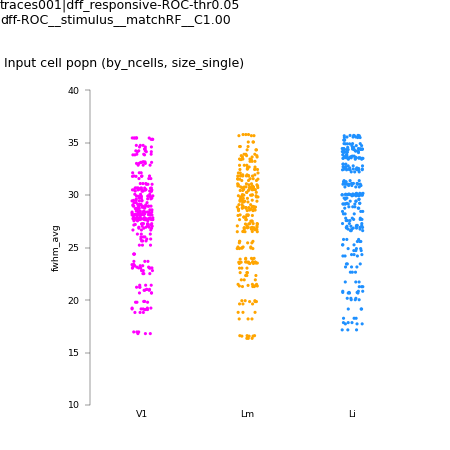

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs input_cell_distribution__dff-ROC__stimulus__matchRF__C1.00


In [359]:
fig, ax = pl.subplots(figsize=(4,4), dpi=150)

sns.stripplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, s=2,
              palette=area_colors, order=visual_areas, zorder=-1000)
# sns.pointplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='k', order=visual_areas, scale=0.5, errwidth=0.5, join=False,
#              markers='_', zorder=1000, ci='sd', estimator=np.median)
ax.set_ylim((10, 40))
pl.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
# sns.boxplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='w', order=visual_areas, fliersize=0)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
fig.text(0.01, 0.85, 'Input cell popn (%s, %s)' % (analysis_type, test_type), 
         fontsize=8)
figname = 'input_cell_distribution__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(curr_dst_dir, figname)

In [252]:
aggr_id

'dff-ROC__stimulus__matchRF__C1.00'

## Load

In [395]:
# max_ncells = 96 #96 # if match_rfs and (responsive_test=='ROC')
max_ncells = 94
special_cases = [169, 120, 46]
experiment = 'gratings' if class_name=='ori' else 'blobs'
i_=[]
for match_rf_flag in [True, False]:
    iterdf_, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=None,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rf_flag, 
                          overlap_thr=0) # if match_rf_flag is False else None)

    sample_sizes = [s for s in sorted(iterdf_['n_cells'].unique()) if s <=max_ncells\
                   and s not in special_cases]
    iterdf_ = iterdf_[iterdf_['n_cells'].isin(sample_sizes)]
    iterdf_['rfs'] = 'matched' if match_rf_flag else 'all'
    iterdf_['match_rfs'] = match_rf_flag
    i_.append(iterdf_)
iterdf = pd.concat(i_, axis=0, ignore_index=True) #.dropna()

(Li) Found 9 paths
(Lm) Found 9 paths
(V1) Found 9 paths
(Li) Found 13 paths
(Lm) Found 13 paths
(V1) Found 13 paths


In [396]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
itershuff, missing_shuff = dec.load_iterdf(meta, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr,
                          shuffle_visual_area=True)

(Li) Found 8 paths
(Lm) Found 8 paths
(V1) Found 8 paths


In [397]:
max_ncells

94

In [398]:
max_ncells=94    
m_=[]
for rf_cond, iterdf_ in iterdf.groupby('rfs'):
    # Group means
    grouper = ['visual_area', 'condition', 'iteration']
    mean_ = dec.average_within_iterations_by_ncells(iterdf_, 
                                analysis_type=analysis_type, test_type=test_type,
                                grouper=grouper) 
    mean_['rfs'] = rf_cond
    #mean_['match_rfs'] = match_rf_flag
    m_.append(mean_)
mean_df = pd.concat(m_, axis=0).reset_index(drop=True)

In [399]:
n_iters = iterdf['iteration'].max() +1
xlabels = [1, 32, 64, 96, max_ncells]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("rfs:", mean_df['rfs'].unique(), mean_df['match_rfs'].unique())

mean_df['novel_labels'] = None
mean_df.loc[mean_df['novel'], 'novel_labels'] = 'novel'
mean_df.loc[~mean_df['novel'], 'novel_labels'] = 'trained'

novel: [False  True]
conditions: ['data' 'shuffled']
rfs: ['all' 'matched'] [False  True]


In [400]:
mean_df.groupby(['visual_area', 'condition', 'train_transform', 'test_transform', 'novel', 'rfs', 'n_cells']).count()

iteration  \
visual_area condition train_transform test_transform novel rfs     n_cells              
Li          data      30.0            30.0           False all     1              500   
                                                                   2              500   
                                                                   4              500   
                                                                   8              500   
                                                                   16             500   
...                                                                               ...   
V1          shuffled  30.0            30.0           False matched 8              500   
                                                                   16             500   
                                                                   32             500   
                                                                   64             500   
                                                                   94             500   

                                                                            fit_time  \
visual_area condition train_transform test_transform novel rfs     n_cells             
Li          data      30.0            30.0           False all     1             500   
                                                                   2             500   
                                                                   4             500   
                                                                   8             500   
                                                                   16            500   
...                                                                              ...   
V1          shuffled  30.0            30.0           False matched 8             500   
                                                                   16            500   
                                                                   32            500   
                                                                   64            500   
                                                                   94            500   

                                                                            score_time  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1               500   
                                                                   2               500   
                                                                   4               500   
                                                                   8               500   
                                                                   16              500   
...                                                                                ...   
V1          shuffled  30.0            30.0           False matched 8               500   
                                                                   16              500   
                                                                   32              500   
                                                                   64              500   
                                                                   94              500   

                                                                            test_score  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1               500   
                                                                   2               500   
                                                                   4               500   
                                                                   8               500   
                                                              

In [401]:
print_index = ['visual_area','rfs', 'novel']

if test_type is not None:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'novel', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=print_index, columns='n_cells')
else:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area'], columns='n_cells')
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: blobs (class=morphlevel): dff-ROC__stimulus__matchRF__C1.00


heldout_test_score                                \
n_cells                                   1         2         4         8    
visual_area rfs     novel                                                    
Li          all     False           0.530741  0.547449  0.561567  0.600500   
                    True            0.521049  0.538623  0.550980  0.583034   
            matched False           0.540259  0.557498  0.585950  0.611650   
                    True            0.539062  0.550440  0.572919  0.597517   
Lm          all     False           0.524667  0.543367  0.565700  0.592767   
                    True            0.515119  0.524139  0.532597  0.541562   
            matched False           0.530533  0.533600  0.555233  0.574000   
                    True            0.513809  0.523837  0.533269  0.542252   
V1          all     False           0.538667  0.564757  0.588667  0.618400   
                    True            0.521386  0.534489  0.548732  0.562304   
            matched False           0.545833  0.577910  0.610400  0.645567   
                    True            0.521503  0.535114  0.555673  0.572433   

                                                                   
n_cells                          16        32        64        94  
visual_area rfs     novel                                          
Li          all     False  0.624000  0.643650  0.703100  0.736683  
                    True   0.602303  0.618422  0.661204  0.683350  
            matched False  0.644050  0.670100  0.727100  0.763717  
                    True   0.620664  0.643338  0.685332  0.707155  
Lm          all     False  0.614700  0.639900  0.685967  0.717933  
                    True   0.555240  0.564990  0.584324  0.600126  
            matched False  0.588567  0.609933  0.639700  0.658167  
                    True   0.558226  0.570302  0.585741  0.596938  
V1          all     False  0.653233  0.691633  0.763100  0.805867  
                    True   0.580481  0.601230  0.640910  0.668083  
            matched False  0.684433  0.723500  0.780867  0.813133  
                    True   0.588818  0.611148  0.648347  0.664966

In [402]:
area_colors2 = {'V1': 'darkmagenta', 'Lm': 'saddlebrown', 'Li': 'darkblue'}

In [403]:
pl.rcParams['legend.title_fontsize'] = 8


<IPython.core.display.Javascript object>


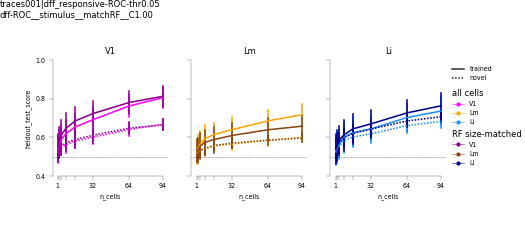

2 [<matplotlib.lines.Line2D object at 0x2b6a6ebcced0>, <matplotlib.lines.Line2D object at 0x2b6a6ebcc550>, <matplotlib.lines.Line2D object at 0x2b6a6e9f3590>, <matplotlib.lines.Line2D object at 0x2b6a6e9f3110>]
1 [<matplotlib.lines.Line2D object at 0x2b6a6d810210>, <matplotlib.lines.Line2D object at 0x2b6a6d810c50>, <matplotlib.lines.Line2D object at 0x2b6a6d818490>, <matplotlib.lines.Line2D object at 0x2b6a6d818bd0>]
2
0 [<matplotlib.lines.Line2D object at 0x2b6a6e9b7850>, <matplotlib.lines.Line2D object at 0x2b6a6e9b7d90>, <matplotlib.lines.Line2D object at 0x2b6a6e9ad650>, <matplotlib.lines.Line2D object at 0x2b6a6d839d10>]
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs accuracy_byncell_curves_matchRF-v-all_train-v-novel


In [404]:
metric='heldout_test_score'

plotd = mean_df[mean_df.condition=='data']

#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)

for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]; ax.set_title(va);
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='all'], ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors[va])
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='matched'],ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors2[va])
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.set_ylim([0.4, 1])
    print(ai, ax.legend_.legendHandles)
    if ai==1:
        leg_h = ax.legend_.legendHandles[0:2]
        print(len(leg_h))
        leg = ax.legend(handles=leg_h, bbox_to_anchor=(2.2,1.), loc='upper left', 
                  frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.legend_.remove()
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_box_aspect(1)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

leg_h2 = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[-1].legend(handles=leg_h2, bbox_to_anchor=(1,0.8), loc='upper left', 
               frameon=False, title='all cells')
leg._legend_box.align = "left"

leg_h3 = pplot.custom_legend_markers(colors=[area_colors2[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[0].legend(handles=leg_h3, bbox_to_anchor=(3.4,0.45), loc='upper left', 
               frameon=False, title='RF size-matched', fontsize=6)
leg._legend_box.align = "left"

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, wspace=0.2, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'accuracy_byncell_curves_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [405]:
import itertools
max_ncells

94

In [406]:
plotd = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]
plotd.head()


,visual_area,condition,iteration,n_cells,novel,fit_time,score_time,test_score,train_score,heldout_test_score,...,randi,train_transform,test_transform,n_trials,randi_cells,intact,overlap_thr,match_rfs,rfs,novel_labels
14,Li,data,0,94,False,0.004265,0.000313,0.653333,1.0,0.725000,...,5326.2,30.0,30.0,38.0,8946.0,True,0.0,False,all,trained
15,Li,data,0,94,True,0.004265,0.000313,0.653333,1.0,0.673684,...,5326.2,30.0,30.0,38.0,8946.0,True,0.0,False,all,novel
30,Li,data,1,94,False,0.002329,0.000826,0.686667,1.0,0.725000,...,6215.2,30.0,30.0,38.0,1041.0,True,0.0,False,all,trained
31,Li,data,1,94,True,0.002329,0.000826,0.686667,1.0,0.685526,...,6215.2,30.0,30.0,38.0,1041.0,True,0.0,False,all,novel
46,Li,data,2,94,False,0.000831,0.000338,0.706222,1.0,0.666667,...,5980.4,30.0,30.0,58.0,6396.0,True,0.0,False,all,trained


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


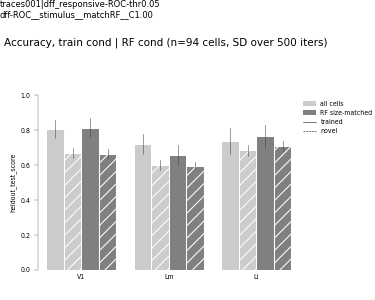

In [407]:
%matplotlib notebook
plotd['plotcond'] = ['%s_%s' %  (r, n) for r, n in plotd[['rfs', 'novel_labels']].values]

matchrf_color = [0.5]*3
all_color = [0.8]*3
plot_palette = {'all_trained': all_color, 'all_novel': all_color,
                'matched_trained': matchrf_color, 'matched_novel': matchrf_color}
keys = ['all_trained', 'all_novel', 'matched_trained', 'matched_novel']

fig, ax = pl.subplots(figsize=(5,4))
sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
           hue='plotcond', hue_order=keys, palette=plot_palette, 
           edgecolor='w', order=visual_areas, ci='sd', errwidth=0.5)
# legends
leg_h = pplot.custom_legend_markers(colors=[all_color, matchrf_color],
                                    labels=['all cells', 'RF size-matched'],
                                    use_patch=True)
leg_h2 = pplot.custom_legend_markers(colors=['k', 'k'],
                                    labels=['trained', 'novel'],markers=None,
                                    linestyles=['-', '--'], use_patch=False)
ax.legend(handles=leg_h+leg_h2, bbox_to_anchor=(0.99,1), 
          loc='upper left', frameon=False)

bar_locs = 3
hatches = itertools.cycle(['', '//'])
for i, bar in enumerate(ax.patches):
    if i % bar_locs == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_aspect(2, anchor='SW')
ax.set_ylim([0, 1])
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
fig.text(0.01, 0.85,\
         'Accuracy, train cond | RF cond (n=%i cells, SD over %i iters)' \
         % (max_ncells, n_iters))

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'compare_performance_matchRF-v-all_train-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [408]:
data_ = mean_df[(mean_df['n_cells']==max_ncells) 
            & (mean_df['condition']=='data')].copy().reset_index(drop=True)
data_.groupby(['visual_area', 'novel', 'rfs']).count()

condition  iteration  n_cells  fit_time  \
visual_area novel rfs                                                
Li          False all            500        500      500       500   
                  matched        500        500      500       500   
            True  all            500        500      500       500   
                  matched        500        500      500       500   
Lm          False all            500        500      500       500   
                  matched        500        500      500       500   
            True  all            500        500      500       500   
                  matched        500        500      500       500   
V1          False all            500        500      500       500   
                  matched        500        500      500       500   
            True  all            500        500      500       500   
                  matched        500        500      500       500   

                           score_time  test_score  train_score  \
visual_area novel rfs                                            
Li          False all             500         500          500   
                  matched         500         500          500   
            True  all             500         500          500   
                  matched         500         500          500   
Lm          False all             500         500          500   
                  matched         500         500          500   
            True  all             500         500          500   
                  matched         500         500          500   
V1          False all             500         500          500   
                  matched         500         500          500   
            True  all             500         500          500   
                  matched         500         500          500   

                           heldout_test_score    C  randi  train_transform  \
visual_area novel rfs                                                        
Li          False all                     500  500    500              500   
                  matched                 500  500    500              500   
            True  all                     500  500    500              500   
                  matched                 500  500    500              500   
Lm          False all                     500  500    500              500   
                  matched                 500  500    500              500   
            True  all                     500  500    500              500   
                  matched                 500  500    500              500   
V1          False all                     500  500    500              500   
                  matched                 500  500    500              500   
            True  all                     500  500    500              500   
                  matched                 500  500    500              500   

                           test_transform  n_trials  randi_cells  intact  \
visual_area novel rfs                                                      
Li          False all                 500       500          500     500   
                  matched             500       500          500     500   
            True  all                 500       500          500     500   
                  matched             500       500          500     500   
Lm          False all                 500       500          500     500   
                  matched             500       500          500     500   
            True  all                 500       500          500     500   
                  matched             500       500          500     500   
V1          False all                 500       500          500     500   
                  matched             500       500          500     500   
            True  all                 500       500          500     500   
                  matched             50

<IPython.core.display.Javascript object>


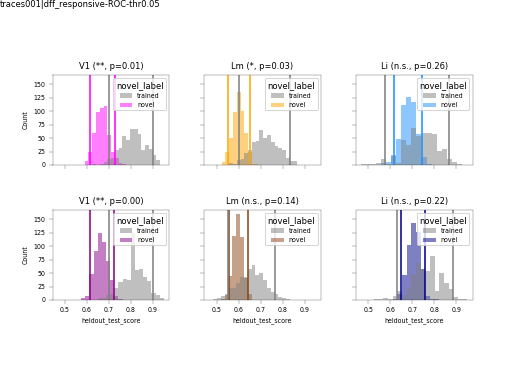

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs distns_95CI_test_trained-v-novel


In [409]:
metric='heldout_test_score'
v1='novel'
v2='trained'
data_['novel_label'] = [v1 if v else v2 for v in data_['novel'].values]
fig, axn = pl.subplots(2,3, figsize=(7,5), sharex=True, sharey=True)

for (va, rf_), vg in data_.groupby(['visual_area', 'rfs']):
    ri=1 if rf_=='matched' else 0
    vi = visual_areas.index(va)
    ax=axn[ri, vi]
    c1 = area_colors2[va] if rf_=='matched' else area_colors[va]
    c2 = [0.5]*3
    sns.histplot(x='heldout_test_score', hue='novel_label', bins=20, data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)

    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.novel][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)
    c_lo, c_hi = hutils.get_empirical_ci(vg[~(vg.novel)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    # Sig test
    # vg = df_[(df_.visual_area==va) & (df_.rfs=='matched')]
    meas_mean = vg[(vg.novel)]['heldout_test_score'].mean()
    trained_dist = sorted(vg[~(vg.novel)]['heldout_test_score'].values)
    n_below = len(np.where(trained_dist<meas_mean)[0])
    pv = n_below/len(trained_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'

    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv))
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
pplot.label_figure(fig, data_id)

figname = 'distns_95CI_test_trained-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


In [410]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs'

In [411]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

# Is this difference significantly greater than chance?

In [412]:
# data_ = mean_df[(mean_df['n_cells']==max_ncells) 
#             & (mean_df['condition']=='data')].copy().reset_index(drop=True)
data_ = iterdf[(iterdf.n_cells==max_ncells) 
               & (iterdf.condition=='data') & (iterdf.iteration<=1000)].copy()

d_list=[]
for rf_cond, data_df in data_.groupby('rfs'):
    diff_ = dec.permutation_test_trained_v_novel(data_df)
    diff_['rfs'] = rf_cond
    d_list.append(diff_.reset_index(drop=True))
diffs = pd.concat(d_list, axis=0, ignore_index=True)

In [413]:
data_[(data_.visual_area==va) & (data_.iteration==1) 
      & (data_.train_transform==10) ] #& (data_.rfs=='all')]

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,condition,train_transform,test_transform,...,novel,iteration,n_cells,randi_cells,visual_area,datakey,intact,overlap_thr,rfs,match_rfs
356280,0.000852,0.000351,0.715556,1.0,0.750000,1.0,3558,data,10.0,10.0,...,False,1,94,7347,V1,aggregate,True,0,matched,True
356282,0.000852,0.000351,0.715556,1.0,0.534483,1.0,3558,data,10.0,20.0,...,True,1,94,7347,V1,aggregate,True,0,matched,True
356283,0.000852,0.000351,0.715556,1.0,0.431034,1.0,3558,data,10.0,30.0,...,True,1,94,7347,V1,aggregate,True,0,matched,True
356284,0.000852,0.000351,0.715556,1.0,0.465517,1.0,3558,data,10.0,40.0,...,True,1,94,7347,V1,aggregate,True,0,matched,True
356285,0.000852,0.000351,0.715556,1.0,0.327586,1.0,3558,data,10.0,50.0,...,True,1,94,7347,V1,aggregate,True,0,matched,True
712530,0.000903,0.000357,0.566667,1.0,0.416667,1.0,5757,data,10.0,10.0,...,False,1,94,332,V1,aggregate,True,0,all,False
712532,0.000903,0.000357,0.566667,1.0,0.551724,1.0,5757,data,10.0,20.0,...,True,1,94,332,V1,aggregate,True,0,all,False
712533,0.000903,0.000357,0.566667,1.0,0.517241,1.0,5757,data,10.0,30.0,...,True,1,94,332,V1,aggregate,True,0,all,False
712534,0.000903,0.000357,0.566667,1.0,0.448276,1.0,5757,data,10.0,40.0,...,True,1,94,332,V1,aggregate,True,0,all,False
712535,0.000903,0.000357,0.566667,1.0,0.431034,1.0,5757,data,10.0,50.0,...,True,1,94,332,V1,aggregate,True,0,all,False


In [414]:
iterdf['iteration'].max()

499

<IPython.core.display.Javascript object>


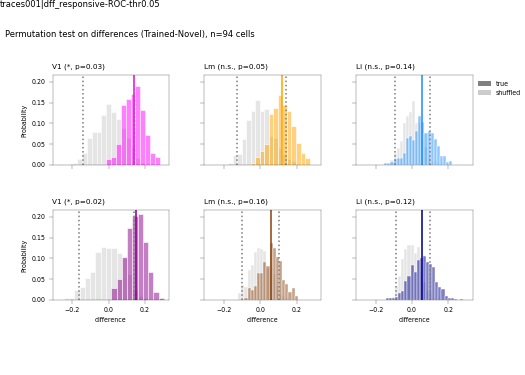

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs permutation_test_trained-v-novel-diffs


In [415]:
shuff_color=[0.8]*3

fig, axn = pl.subplots(2,3, figsize=(7,5), sharex=True, sharey=True)

for (va, rf_), vg in diffs.groupby(['visual_area', 'rfs']):
    ri=1 if rf_=='matched' else 0
    vi = visual_areas.index(va)
    ax=axn[ri, vi]

    curr_colors= area_colors2.copy() if rf_=='matched' else area_colors.copy()
    sns.histplot(x='difference', hue='trained_v_novel', data=vg, ax=ax, alpha=0.5,
                palette={'shuffled': shuff_color, 'true': curr_colors[va]},
                stat='probability', legend=True, common_norm=False,
                edgecolor='w')
    
    meas_mean = vg[vg.trained_v_novel=='true']['difference'].mean()
    ax.axvline(x=meas_mean, color=curr_colors[va])
    shuff_dist = sorted(vg[vg.trained_v_novel=='shuffled']['difference'].values)
    n_extreme = len(np.where(shuff_dist>=meas_mean)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv), loc='left', fontsize=7)
    
    c_lo, c_hi = hutils.get_empirical_ci(shuff_dist)
    ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
    ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    if ri==0 and va=='Li':
        leg_h = pplot.custom_legend_markers(colors=[[0.5]*3, shuff_color],
                                           labels=['true', 'shuffled'], 
                                           use_patch=True)
        ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=None)
    else:
        ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
fig.text(0.01, 0.9,\
         "Permutation test on differences (Trained-Novel), n=%i cells" \
         % max_ncells, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'permutation_test_trained-v-novel-diffs'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [416]:
diffs[diffs.trained_v_novel=='true'].groupby(['visual_area', 'rfs'])['difference'].describe()

count      mean       std       min       25%       50%  \
visual_area rfs                                                                
Li          all      500.0  0.053334  0.068862 -0.153161  0.007566  0.053592   
            matched  500.0  0.056562  0.064775 -0.144737  0.010265  0.056594   
Lm          all      500.0  0.117807  0.060106 -0.042816  0.074425  0.116523   
            matched  500.0  0.061229  0.058092 -0.079885  0.020618  0.062500   
V1          all      500.0  0.137784  0.054064 -0.027011  0.099425  0.139799   
            matched  500.0  0.148168  0.053539 -0.047989  0.113147  0.150287   

                          75%       max  
visual_area rfs                          
Li          all      0.102632  0.222368  
            matched  0.100975  0.281579  
Lm          all      0.160704  0.270977  
            matched  0.101437  0.206609  
V1          all      0.174138  0.281034  
            matched  0.186279  0.286207

In [417]:
# data_ = iterdf[(iterdf.n_cells==max_ncells) & (iterdf.condition=='data')].copy()
data_ = iterdf[(iterdf.n_cells==max_ncells) 
               & (iterdf.condition=='data') ].copy()

# d_list=[]
# for rf_cond, data_df in data_.groupby('rfs'):
#     diff_ = dec.permutation_test_trained_v_novel(data_df)
#     diff_['rfs'] = rf_cond
#     d_list.append(diff_.reset_index(drop=True))
# diffs = pd.concat(d_list, axis=0, ignore_index=True)
d_list=[]
for rf_cond, data_df in data_.groupby('rfs'):
    data_scores = dec.average_within_iterations_by_ncells(data_df, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'iteration'])
    true_ = dec.calculate_difference_scores(data_scores)
    true_['rfs'] = rf_cond
    true_['condition'] = 'true'
    d_list.append(true_.reset_index(drop=True))
trained_minus_novel_true = pd.concat(d_list, axis=0, ignore_index=True)
trained_minus_novel_true.head()

,visual_area,n_cells,iteration,difference,rfs,condition
0,Li,94,0,0.051316,all,true
1,Lm,94,0,0.147126,all,true
2,V1,94,0,0.232759,all,true
3,Li,94,1,0.039474,all,true
4,Lm,94,1,0.158621,all,true


In [418]:
d_list=[]
shuff_ = data_.copy()
shuff_['rfs'] = shuff_.groupby(\
                        ['visual_area', 'iteration', 'novel'])['rfs']\
                        .transform(np.random.permutation)
for rf_cond, data_df in shuff_.groupby('rfs'):
    shuff_scores = dec.average_within_iterations_by_ncells(data_df, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'condition', 'iteration'])
    shuff_ = dec.calculate_difference_scores(shuff_scores)
    shuff_['rfs'] = rf_cond
    shuff_['condition'] = 'shuffled'
    d_list.append(shuff_.reset_index(drop=True))

trained_minus_novel_shuff = pd.concat(d_list, axis=0, ignore_index=True)

In [419]:
trained_minus_novel = pd.concat([trained_minus_novel_true, 
                                trained_minus_novel_shuff], axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


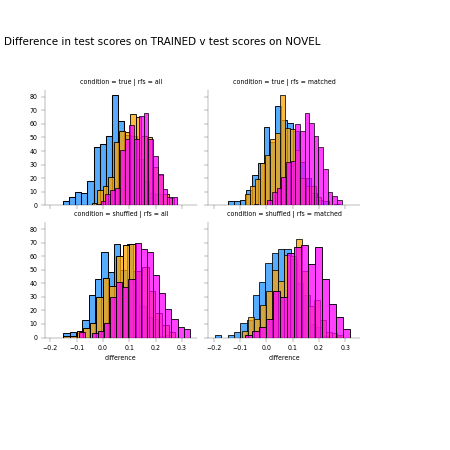

Text(0.01, 0.9, 'Difference in test scores on TRAINED v test scores on NOVEL')

In [420]:
#fig, axn = pl.subplots(1, 2, figsize=(6,3))
#ax=axn[0]

fg = sns.FacetGrid(col='rfs', data=trained_minus_novel, height=3, 
                  hue='visual_area', palette=area_colors,
                   row='condition')
fg.map(sns.histplot, 'difference')

# sns.histplot(x='difference', data=true_diffs[true_diffs], ax=ax,
#              hue='visual_area', palette=area_colors)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8)
fg.fig.text(0.01, 0.9, 'Difference in test scores on TRAINED v test scores on NOVEL')

<IPython.core.display.Javascript object>


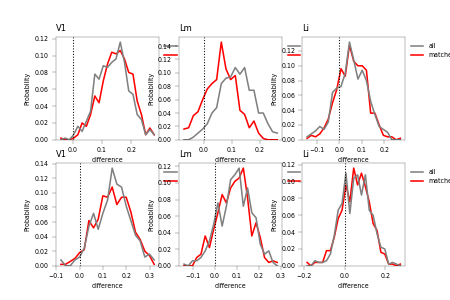

In [421]:
rf_cond_colors={'all': [0.5]*3, 'matched': 'r'}
fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)

for (cond, va), curr_scores in trained_minus_novel.groupby(['condition', 'visual_area']):
    ri=0 if cond=='true' else 1
    ax=axn[ri, visual_areas.index(va)]
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 cumulative=False, common_norm=False,
                 fill=False, element='poly', stat='probability', 
                 palette=rf_cond_colors, hue='rfs')
    ax.axvline(x=0, ls=':', c='k', lw=1)
    pplot.sns_histplot_legend(ax, title='')
    ax.set_title(va, loc='left')
    ax.set_box_aspect(1)
    

<IPython.core.display.Javascript object>


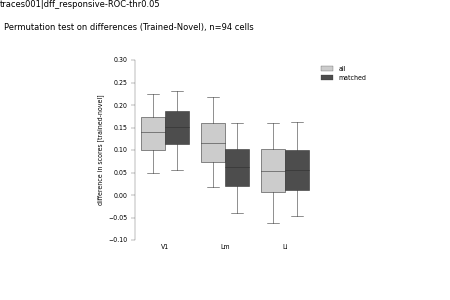

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs boxplot_match_vs_unmatched_trained-v-novel-diffs
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/generalization boxplot_match_vs_unmatched_trained-v-novel-diffs


In [422]:

rf_cond_colors={'all': [0.8]*3, 'matched': [0.3]*3}
fig, ax = pl.subplots( figsize=(6,4), dpi=100)
plotd =trained_minus_novel[trained_minus_novel.condition=='true']

sns.boxplot(x='visual_area', y='difference', data=plotd,
           ax=ax, hue='rfs', order=visual_areas, palette=rf_cond_colors,
            linewidth=0.5, fliersize=0, whis=(5, 95))
ax.set_box_aspect(1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True)
ax.set_xlabel('')
ax.set_ylim([-0.1, 0.3])
ax.set_ylabel('difference in scores [trained-novel]')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
fig.text(0.01, 0.9,\
         "Permutation test on differences (Trained-Novel), n=%i cells" \
         % max_ncells, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'boxplot_match_vs_unmatched_trained-v-novel-diffs'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(FIGDIR, figname)

In [423]:
df_list=[]
for va, vg in trained_minus_novel_true.groupby('visual_area'):
    for i in np.arange(0, 500):
        d_ = vg.sample(2, replace=False)
        random_diff = d_.iloc[0]['difference'] - d_.iloc[1]['difference']
        df_ = pd.Series({'difference': random_diff, 
                  'visual_area': va, 'condition': 'shuffled'})
        df_list.append(df_)
randsamp = pd.concat(df_list, axis=1).T

<IPython.core.display.Javascript object>


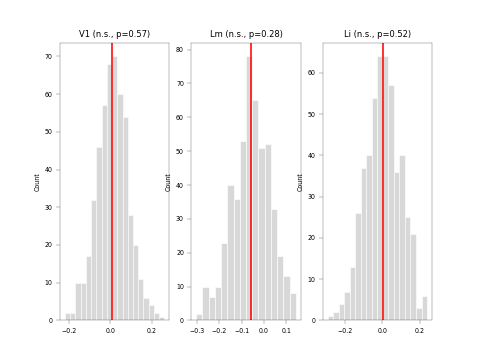

In [425]:
fig, axn = pl.subplots(1,3)

for va, vg in trained_minus_novel_true.groupby(['visual_area']):
    ax=axn[visual_areas.index(va)]
    # shuff_dist = randsamp[randsamp.visual_area==va]['difference'].values
    #sns.histplot(vg['difference'], ax=ax, color=[0.8]*3, edgecolor='w')
    true_diffs = vg[vg.rfs=='matched']['difference'].values \
                - vg[vg.rfs=='all']['difference'].values
    true_meandiff = np.mean(true_diffs)
    sns.histplot(true_diffs, ax=ax, color=[0.8]*3, edgecolor='w')
    ax.axvline(x=true_meandiff, color='r')
    
    sorted_dist = np.array(sorted(true_diffs))
    n_extreme = len(np.where(sorted_dist>=0)[0])
    pv = n_extreme/len(sorted_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.set_title("%s (%s, p=%.2f)" % (va, sig_str, pv))

In [379]:
vg[vg.rfs=='matched'].values 

array([['Li', 94, 0, 0.007894736842105066, 'matched', 'true'],
       ['Li', 94, 1, 0.08552631578947378, 'matched', 'true'],
       ['Li', 94, 2, 0.05657894736842095, 'matched', 'true'],
       ...,
       ['Li', 94, 497, 0.12816091954023, 'matched', 'true'],
       ['Li', 94, 498, 0.043421052631578805, 'matched', 'true'],
       ['Li', 94, 499, 0.1218390804597701, 'matched', 'true']],
      dtype=object)

In [426]:
df_list=[]
for cond, cg in trained_minus_novel.groupby(['condition', 'visual_area']):
    df_ = cg.sort_values(by='iteration').reset_index(drop=True)
    diff_vals = df_[df_.rfs=='matched']['difference'].values \
                - df_[df_.rfs=='all']['difference'].values
    new_df = df_[['visual_area', 'iteration', 'condition']].drop_duplicates()
    new_df['difference'] = diff_vals
    df_list.append(new_df)
matched_minus_unmatched = pd.concat(df_list, axis=0, ignore_index=True)


<IPython.core.display.Javascript object>


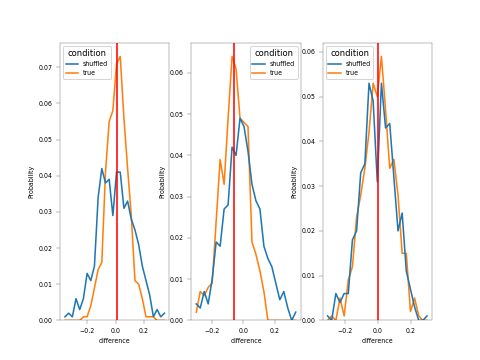

In [435]:
# sns.displot(x='difference', col='visual_area', col_order=visual_areas, 
#             data=matched_minus_unmatched,
#             hue='condition', height=2, cumulative=True, fill=False)

fig, axn = pl.subplots(1,3)
for va, vg in matched_minus_unmatched.groupby(['visual_area']):
    ax=axn[visual_areas.index(va)]
    # shuff_dist = randsamp[randsamp.visual_area==va]['difference'].values
    #sns.histplot(vg['difference'], ax=ax, color=[0.8]*3, edgecolor='w')
    sns.histplot(x='difference', ax=ax, data=vg, #edgecolor='w',
                 hue='condition', cumulative=False, common_norm=True,
                 stat='probability', element='poly', fill=False)
    meanv = vg[vg.condition=='true'].mean()['difference']
    
    ax.axvline(x=meanv, color='r')
    
#     sorted_dist = np.array(sorted(true_diffs))
#     n_extreme = len(np.where(sorted_dist>=0)[0])
#     pv = n_extreme/len(sorted_dist)
#     if pv<0.05:
#         sig_str='**' if pv<0.01 else '*'
#     else:
#         sig_str='n.s.'
#     ax.set_title("%s (%s, p=%.2f)" % (va, sig_str, pv))

In [434]:
vg[vg.condition=='true'].mean()

iteration     249.500000
difference      0.010384
dtype: float64

In [192]:
# true_diffs = diff_scores[diff_scores.condition=='true'].copy()
# shuff_diffs = diff_scores[diff_scores.condition=='shuffled'].copy()
va='Lm'
# vg[vg.rfs=='all'], vg[vg.rfs=='matched']

In [197]:
vg = diff_scores[diff_scores.visual_area==va]
vg

,visual_area,n_cells,iteration,difference,rfs,condition
1,Lm,96,0,0.142816,all,true
4,Lm,96,1,0.197989,all,true
7,Lm,96,2,0.049713,all,true
10,Lm,96,3,0.039080,all,true
13,Lm,96,4,0.084483,all,true
...,...,...,...,...,...,...
5986,Lm,96,495,0.156034,matched,shuffled
5989,Lm,96,496,0.095115,matched,shuffled
5992,Lm,96,497,0.050575,matched,shuffled
5995,Lm,96,498,0.021839,matched,shuffled


<IPython.core.display.Javascript object>


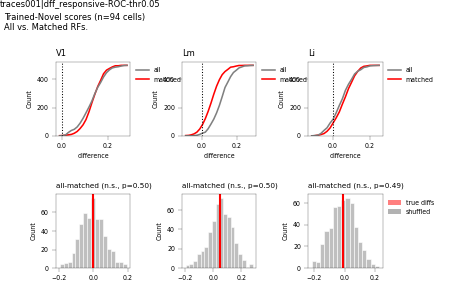

Text(0.01, 0.9, 'Trained-Novel scores (n=94 cells)\nAll vs. Matched RFs.')

In [206]:
rf_cond_colors={'all': [0.5]*3, 'matched': 'r'}
fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)

diff_df = diff_scores[diff_scores.condition=='true']

for va, curr_scores in diff_df.groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[0, vi]
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 cumulative=True, common_norm=False,
                 fill=False, element='poly',
                 palette=rf_cond_colors, hue='rfs')
    ax.axvline(x=0, ls=':', c='k', lw=1)
    pplot.sns_histplot_legend(ax, title='')
    ax.set_title(va, loc='left')

    ax=axn[1, vi]
    v1_vals = curr_scores[curr_scores.rfs=='all'].sort_values(by='iteration')\
                ['difference'].values
    v2_vals = curr_scores[curr_scores.rfs=='matched'].sort_values(by='iteration')\
                ['difference'].values
    curr_diffs = v1_vals - v2_vals
    true_diff = np.mean(curr_diffs)

    sns.histplot(curr_diffs, ax=ax, color=[0.5]*3, alpha=0.5, edgecolor='w')
    sorted_dist = np.array(sorted(curr_diffs))
    n_extreme = len(np.where(sorted_dist<=true_diff)[0])
    pv = n_extreme/len(sorted_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    if vi==2:
        legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                    labels=['true diffs', 'shuffled'], 
                                    use_patch=True, alpha=0.5)
        ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.axvline(x=true_diff, ls='-', c='r', lw=2)
    #ax.axvline(x=shuff_diff, ls='-', c='k', lw=2)
    ax.set_title('all-matched (%s, p=%.2f)' % (sig_str, pv),
                 loc='left', fontsize=7)
    
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.7, hspace=0.7, bottom=0.1, top=0.8, right=0.85)

pplot.label_figure(fig,data_id)
fig.text(0.01, 0.9, 
    'Trained-Novel scores (n=%i cells)\nAll vs. Matched RFs.' \
         % max_ncells, fontsize=8)

In [210]:
diff_scores

,visual_area,n_cells,iteration,difference,rfs,condition
0,Li,96,0,0.097414,all,true
1,Lm,96,0,0.142816,all,true
2,V1,96,0,0.166667,all,true
3,Li,96,1,0.090789,all,true
4,Lm,96,1,0.197989,all,true
...,...,...,...,...,...,...
5995,Lm,96,498,0.021839,matched,shuffled
5996,V1,96,498,0.099713,matched,shuffled
5997,Li,96,499,0.026830,matched,shuffled
5998,Lm,96,499,0.079598,matched,shuffled


<IPython.core.display.Javascript object>


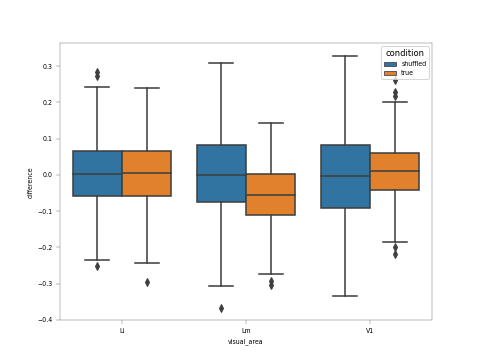

<AxesSubplot:xlabel='visual_area', ylabel='difference'>

In [339]:
fig, ax = pl.subplots()
sns.boxplot(x='visual_area', y='difference', ax=ax,
            data=matched_minus_unmatched, hue='condition')


<IPython.core.display.Javascript object>


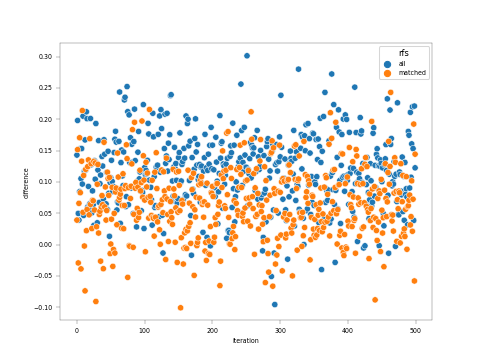

,iteration,difference,rfs
1,0,0.142816,all
4,1,0.197989,all
7,2,0.049713,all
10,3,0.039080,all
13,4,0.084483,all
...,...,...,...
2986,495,0.021264,matched
2989,496,0.072414,matched
2992,497,0.192241,matched
2995,498,-0.058046,matched


In [208]:
fig, ax = pl.subplots()

va='Lm'
curr_scores = diff_scores[(diff_scores.visual_area==va)
                         & (diff_scores.condition=='true')]

# v1_vals = curr_scores[curr_scores.rfs=='all'].sort_values(by='iteration')\
#             ['difference'].values
# v2_vals = curr_scores[curr_scores.rfs=='matched'].sort_values(by='iteration')\
#             ['difference'].values

sns.scatterplot(x='iteration', y='difference', data=curr_scores, ax=ax,
                hue='rfs')

curr_scores[['iteration', 'difference', 'rfs']]

In [149]:
v1_vals = curr_scores[curr_scores.rfs=='all']['difference'].values
v2_vals = curr_scores[curr_scores.rfs=='matched']['difference'].values
v1_mean = v1_vals.mean()
v2_mean = v2_vals.mean()
overall_mean = curr_scores['difference'].mean()


In [150]:
h0_v1 = (v1_vals - v1_mean) + overall_mean 
h0_v2 = (v2_vals - v2_mean) + overall_mean 

h0_diff= h0_v1-h0_v2
hA_diff= v1_vals-v2_vals


<IPython.core.display.Javascript object>


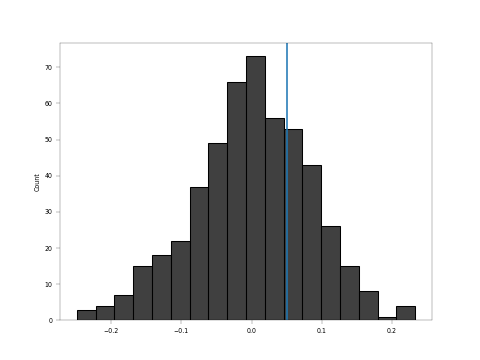

143.00199600798402


In [156]:
fig, ax = pl.subplots()
sns.histplot(h0_diff, color='k')
# sns.histplot(hA_diff, color='r')
ax.axvline(x=hA_diff.mean())

p_larger = len(np.where(h0_diff>=hA_diff.mean())[0])
print(p_larger+1/(len(hA_diff)+1))

In [ ]:
print(p_larger+1/(len(hA_diff)+1))

In [160]:
p_larger/500.

0.286

In [157]:
(len(hA_diff)+1)

501

<IPython.core.display.Javascript object>


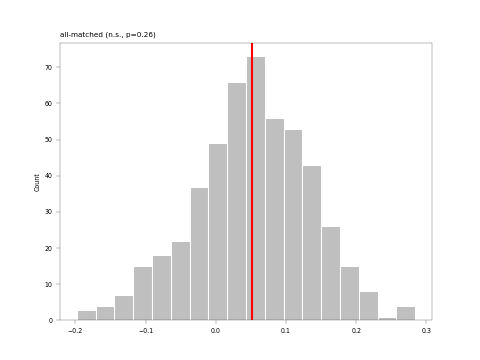

Text(0.0, 1.0, 'all-matched (n.s., p=0.26)')

In [135]:
v1_df = curr_scores[curr_scores.rfs=='all'][['iteration', 'difference', 'rfs']].copy()
v2_df = curr_scores[curr_scores.rfs=='matched'][['iteration', 'difference', 'rfs']].copy()

fig, ax = pl.subplots()
diffs_ = pd.merge(v1_df, v2_df, on=['iteration'], how='outer', 
             suffixes=('_all', '_matched'))
curr_diffs = diffs_['difference_all'] - diffs_['difference_matched']
true_diff = curr_diffs.mean()

sorted_dist = np.array(sorted(curr_diffs))
sns.histplot(sorted_dist, ax=ax, color=[0.5]*3,alpha=0.5, edgecolor='w')
n_extreme = len(np.where(sorted_dist<=0)[0])
pv = n_extreme/len(sorted_dist)
if pv<0.05:
    sig_str='**' if pv<0.01 else '*'
else:
    sig_str='n.s.'
if vi==2:
    legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                labels=['true diffs', 'shuffled'], 
                                use_patch=True, alpha=0.5)
    ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
ax.axvline(x=true_diff, ls='-', c='r', lw=2)
ax.set_title('all-matched (%s, p=%.2f)' % (sig_str, pv),
             loc='left', fontsize=7)

In [129]:
import scipy.stats as spstats
from statsmodels.graphics.gofplots import qqplot


In [126]:
spstats.normaltest(curr_diffs, axis=0)

NormaltestResult(statistic=3.12901041351077, pvalue=0.20919149410845364)

<IPython.core.display.Javascript object>


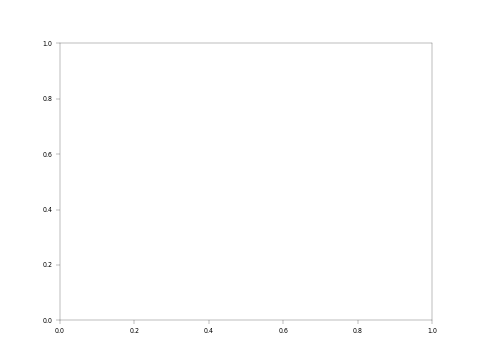

<IPython.core.display.Javascript object>


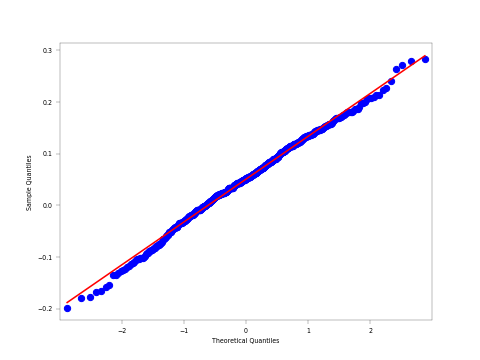

Statistics=0.996, p=0.179
Sample looks Gaussian (fail to reject H0)


In [133]:
fig, ax = pl.subplots()
qqplot(curr_diffs, line='s')

# normality test
stat, p = spstats.shapiro(curr_diffs)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
    

<IPython.core.display.Javascript object>


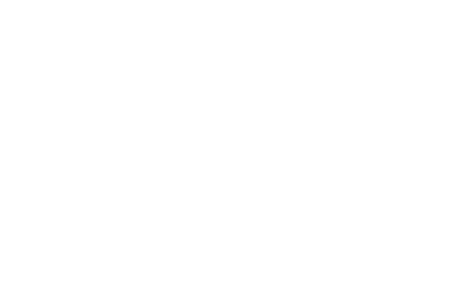

NameError: name 'shuff_diff' is not defined

In [63]:
%matplotlib notebook
# v1='Li'
# v2 = 'Lm'
v_combos = list(itertools.combinations(visual_areas, 2))
s_list=[]
fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)
for vi, (v1, v2) in enumerate(v_combos):
    # Original diff. distributions
    curr_scores = diff_scores[diff_scores.visual_area.isin([v1, v2])].copy()
    ax=axn[0, vi]
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 palette=area_colors, hue='visual_area', edgecolor='w')
    ax.axvline(x=0, ls=':', c='k', lw=1)
    pplot.sns_histplot_legend(ax, title='')
    
    v1_vals = diff_scores[diff_scores.visual_area==v1]['difference'].values
    v2_vals = diff_scores[diff_scores.visual_area==v2]['difference'].values
    curr_diffs = v1_vals - v2_vals
    true_diff = np.mean(curr_diffs)

    # diffs
    ax=axn[1, vi]
    sns.histplot(curr_diffs, ax=ax, color=[0.5]*3, alpha=0.5, edgecolor='w')
    sorted_dist = np.array(sorted(curr_diffs))
    n_extreme = len(np.where(sorted_dist>=true_diff)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    if vi==2:
        legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                    labels=['true diffs', 'shuffled'], 
                                    use_patch=True, alpha=0.5)
        ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.axvline(x=true_diff, ls=':', c='r', lw=1)
    ax.set_title('%s-%s (%s, p=%.2f)' % (v1, v2, sig_str, pv),
                 loc='left', fontsize=7)
    stats0 = pd.Series({'v1': v1, 'v2': v2, 'true_diff': true_diff,
                       'shuff_diff': shuff_diff, 'p-val': pv})
    s_list.append(stats0)
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.7, hspace=0.7, bottom=0.1, right=0.85)

# pplot.label_figure(fig,data_id)
# fig.text(0.01, 0.9, 
#     'Trained-Novel scores (n=%i cells)\nTrue diffs. vs Shuffle area labels' \
#          % curr_ncells, fontsize=8)

# figname = 'trained_vs_novel_shuffle_area_labels_n%icells' % curr_ncells

# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [33]:
import pingouin as pg

In [36]:
score_list=[]
for rf_cond, df_ in data_.groupby(['rfs']):
    byiter = dec.average_within_iterations_by_ncells(df_, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'condition', 'iteration'])
    scores_ = dec.calculate_difference_scores(byiter)
    scores_['rfs'] = rf_cond
    score_list.append(scores_)
all_scores0 = pd.concat(score_list, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


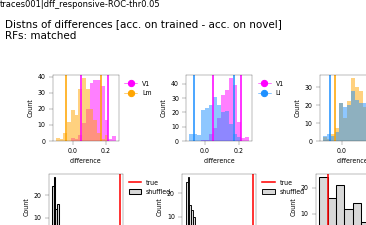

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs compare_by_area_difference_scores_rfs-matched


In [37]:
max_iter=200
n_shuff=100
p_vals = []
metric='difference'
v_combos = list(itertools.combinations(visual_areas, 2))

rfs_cond='matched'
all_scores = all_scores0[all_scores0.rfs==rfs_cond].copy()

fig, axn = pl.subplots(2, len(v_combos), figsize=(6.5,4))
for ai, (v1, v2) in enumerate(v_combos):
    v_list = [v1, v2]
    a_ = all_scores[all_scores.visual_area==v1][metric]
    b_ = all_scores[all_scores.visual_area==v2][metric]
    true_ = abs(a_.mean() - b_.mean())

    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(n_shuff):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:max_iter])
        v = np.mean(combined_[max_iter:])
        diff_s = abs(i-v)
        shuff_.append(diff_s)
    shuff = np.array(shuff_)
    pv_ = len(np.where(shuff>=true_)[0])/n_shuff
    p_vals.append(pd.Series({'v1': v1, 'v2': v2, 'p_val': pv_}))
    
    ax=axn[1, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    ax=axn[0, ai]
    c1= area_colors[v1]
    c2 = c2=area_colors[v2]
    sns.histplot(x=metric, hue='visual_area', ax=ax,
                 data=all_scores[all_scores.visual_area.isin(v_list)], 
                 palette={v1:c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(all_scores[all_scores.visual_area==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(all_scores[all_scores.visual_area==v2][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.75, wspace=0.8, hspace=0.5)
fig.text(0.01, 0.87, \
         "Distns of differences [acc. on trained - acc. on novel]\nRFs: %s" % rfs_cond)

pplot.label_figure(fig, data_id)
figname = 'compare_by_area_difference_scores_rfs-%s' % rfs_cond
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [255]:
p_vals

[v1        V1
 v2        Lm
 p_val    0.0
 dtype: object,
 v1        V1
 v2        Li
 p_val    0.0
 dtype: object,
 v1        Lm
 v2        Li
 p_val    0.0
 dtype: object]

In [241]:
pval_df = pd.concat(p_vals, axis=1).T
pval_df['p_val'] = pval_df['p_val'].astype(float)
pval_df

,v1,v2,p_val
0,V1,Lm,0.000
1,V1,Li,0.000
2,Lm,Li,0.968


In [239]:
reject, pvals_corr = pg.multicomp(pval_df['p_val'].values, method='bonf')
print(reject, pvals_corr)

[False  True  True] [0.096 0.    0.   ]


In [216]:
v1 ='Li'
v2 = 'V1'
a = all_scores[all_scores.visual_area==v1]['difference'].values
b =  all_scores[all_scores.visual_area==v2]['difference'].values

n_extreme = len(np.where(a>=b)[0])
pv = n_extreme/len(shuff_diff_scores)
print(pv, n_extreme)

0.194 97


<IPython.core.display.Javascript object>


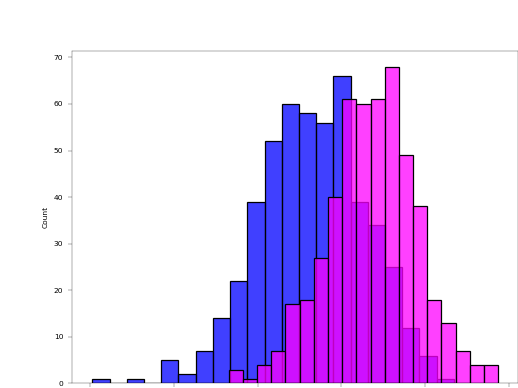

<AxesSubplot:ylabel='Count'>

In [217]:
fig, ax = pl.subplots()
sns.histplot(a, color='blue', ax=ax)
sns.histplot(b, color='magenta', ax=ax)

In [225]:
v1='V1'
v2='Lm'
curr_areas = [v1, v2]
df_ = all_scores[(all_scores.visual_area.isin(curr_areas))].copy()
# df_['difference_abs'] = df_['difference'].abs()
#diff_in_diffscore = df_
mean1 = df_[df_.visual_area==v1]['difference'].mean()
mean2 = df_[df_.visual_area==v2]['difference'].mean()
meas_diff = (mean1-mean2)
# true_diff_scores = (df_[df_.visual_area==v1]['difference'].values \
#                         - df_[df_.visual_area==v2]['difference'].values)
# meas_diff
meas_diff

0.007283333333333308

In [226]:
# df_['visual_area'] = df_.groupby(['iteration'])['visual_area'].transform(np.random.permutation)

In [227]:
# df_['visual_area'] = df_['visual_area'].sample(frac=1).values
# shuff_diff_scores = (df_[df_.visual_area==v1]['difference'].values \
#                         - df_[df_.visual_area==v2]['difference'].values)

In [228]:
n_iters = 500
shuff_diff_scores = []
for i in range(n_iters):
    randi = np.random.randint(0, 1000)
    df_['visual_area'] = df_['visual_area'].sample(frac=1, random_state=randi).values
    mean1 = df_[df_.visual_area==v1]['difference'].mean()
    mean2 = df_[df_.visual_area==v2]['difference'].mean()
    diff_ = (mean1-mean2)
    shuff_diff_scores.append(diff_)
               

<IPython.core.display.Javascript object>


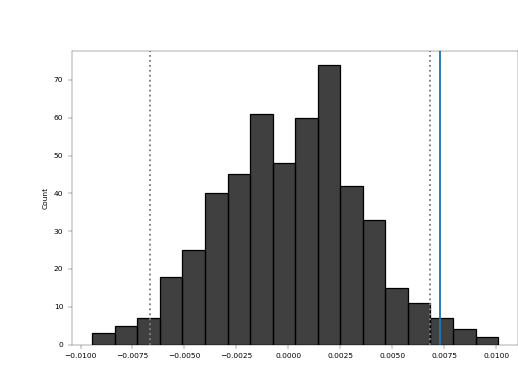

0.02


In [229]:
fig, ax = pl.subplots()
sns.histplot(shuff_diff_scores, color='k')
#sns.histplot(true_diff_scores, color='r')

c_lo, c_hi = hutils.get_empirical_ci(shuff_diff_scores)
ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    
ax.axvline(x=meas_diff)
pl.subplots_adjust(bottom=0.2)

n_extreme = len(np.where(shuff_diff_scores>=meas_diff)[0])
pv = n_extreme/len(shuff_diff_scores)
print(pv)


0.024


<IPython.core.display.Javascript object>


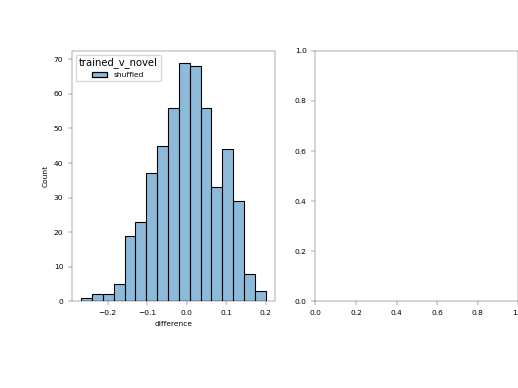

In [83]:
vg = diffs[(diffs.visual_area=='V1') & (diffs.rfs=='matched')
          & (vg.trained_v_novel=='shuffled')].copy()
vg[vg.trained_v_novel=='shuffled']
fig, axn = pl.subplots(1,2)
ax=axn[0]
sns.histplot(x='difference', data=vg, hue='trained_v_novel', ax=ax)
pl.subplots_adjust(bottom=0.3)

In [126]:
vg.groupby(['rfs', 'trained_v_novel']).count()

visual_area  n_cells  iteration  difference
rfs     trained_v_novel                                             
matched shuffled                 500      500        500         500
        true                     500      500        500         500

In [127]:
vg[vg.trained_v_novel=='shuffled']

,visual_area,n_cells,iteration,difference,trained_v_novel,rfs
4502,V1,96,0,-0.085057,shuffled,matched
4505,V1,96,1,0.172989,shuffled,matched
4508,V1,96,2,0.186782,shuffled,matched
4511,V1,96,3,0.011494,shuffled,matched
4514,V1,96,4,-0.101149,shuffled,matched
...,...,...,...,...,...,...
5987,V1,96,495,-0.133908,shuffled,matched
5990,V1,96,496,-0.148276,shuffled,matched
5993,V1,96,497,-0.121264,shuffled,matched
5996,V1,96,498,-0.139655,shuffled,matched


<IPython.core.display.Javascript object>


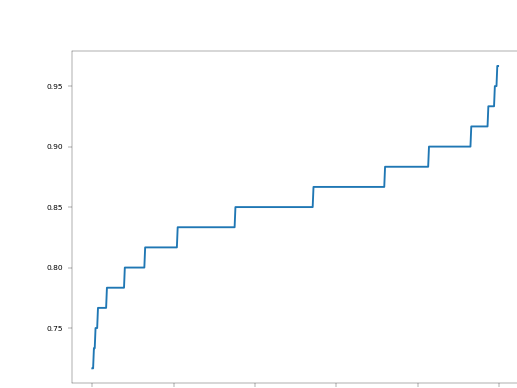

In [75]:
pl.figure()
pl.plot(vg[~(vg.novel)].sort_values(by='heldout_test_score')['heldout_test_score'].values)


In [32]:
data_df = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]


In [33]:
data_df.groupby(['visual_area', 'rfs', 'novel']).count()

condition  iteration  n_cells  fit_time  \
visual_area rfs     novel                                            
Li          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
Lm          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
V1          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   

                           score_time  test_score  train_score  \
visual_area rfs     novel                                        
Li          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
Lm          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
V1          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   

                           heldout_test_score    C  randi  train_transform  \
visual_area rfs     novel                                                    
Li          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
Lm          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
V1          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   

                           test_transform  n_trials  randi_cells  intact  \
visual_area rfs     novel                                                  
Li          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
Lm          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
V1          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              50

In [36]:
d_list=[]
for (va, rf_cond), cg in data_df.sort_values(by='iteration')\
                .groupby(['visual_area', 'rfs']):
    novel_scores = cg[cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    trained_scores = cg[~cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    diffs = trained_scores - novel_scores
    df_ = pd.DataFrame({'trained_minus_novel': diffs})
    df_['visual_area'] = va
    df_['condition'] = 'data'
    df_['rfs'] = rf_cond
    df_['iteration'] = cg[cg.novel].sort_values(by='iteration')['iteration'].values
    d_list.append(df_)
diffdf = pd.concat(d_list, axis=0)

<IPython.core.display.Javascript object>


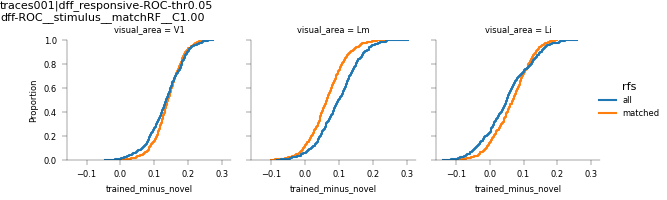

In [37]:
# fig, ax = pl.subplots()
g = sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='ecdf', 
           )
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(g.fig, '%s\n%s' % (data_id, aggr_id))

figname = 'diff_trained-minus-novel_matchrf-v-all'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


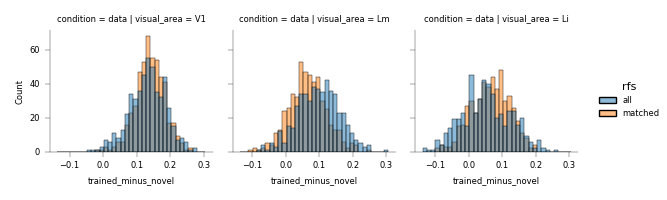

In [38]:
sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='hist', row='condition'
           )

<IPython.core.display.Javascript object>


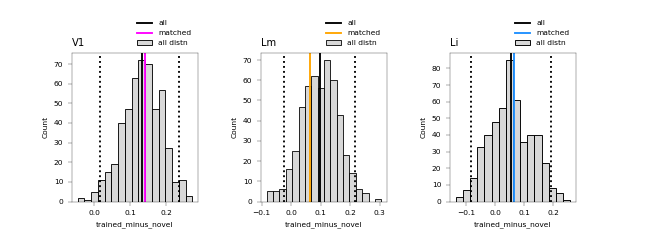

In [50]:
metric='trained_minus_novel'
fig, axn = pl.subplots(1,3, figsize=(8,3))

for va, vg in diffdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x=metric, data=vg[vg['rfs']=='all'], ax=ax,
            color=[0.8]*3, label='all distn')
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg['rfs']=='all'][metric].values, ci=0.95)
    ax.axvline(x=c_lo, color='k', ls=':')
    ax.axvline(x=c_hi, color='k', ls=':')
    mean_v0 = vg[vg['rfs']=='all'][metric].mean()
    ax.axvline(x=mean_v0, color='k', label='all')
    
    # sns.histplot(x='trained_minus_novel', data=plotd[plotd['rfs']=='matched'], ax=ax)
    mean_v = vg[vg['rfs']=='matched'][metric].mean()
    ax.axvline(x=mean_v, color=area_colors[va], label='matched')
    ax.set_title(va, loc='left')
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False)
    
pl.subplots_adjust(bottom=0.25, right=0.8, left=0.1, wspace=0.5, top=0.8)

In [51]:
df_ = diffdf[(diffdf['condition']=='data')].copy()
df_.groupby(['visual_area', 'rfs']).count()

trained_minus_novel  condition  iteration
visual_area rfs                                               
Li          all                      500        500        500
            matched                  500        500        500
Lm          all                      500        500        500
            matched                  500        500        500
V1          all                      500        500        500
            matched                  500        500        500

<IPython.core.display.Javascript object>


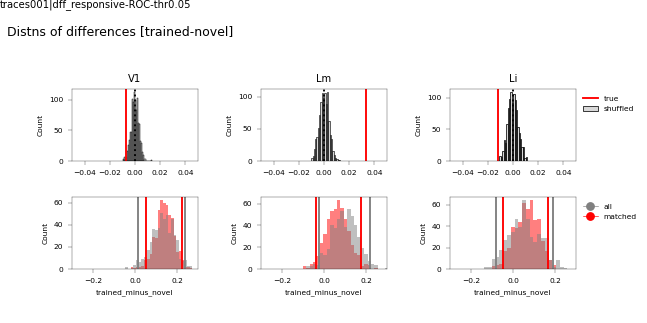

1.0
0.0


No handles with labels found to put in legend.


0.0
1.0
0.985
0.015
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls shuffle_test_DIFF_distn


In [61]:
v1='all'
v2='matched'
c1=[0.5]*3
c2='r'
fig, axn = pl.subplots(2, 3, figsize=(8,4))
for va, vg in diffdf.groupby(['visual_area']):
    # Shuffle test
    a_ = vg[(vg.rfs=='matched')][metric]
    b_ = vg[(vg.rfs=='all')][metric]
    true_ = b_.mean() - a_.mean()
    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(1000):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:500])
        v = np.mean(combined_[500:])
        shuff_.append(i-v)
    shuff = np.array(shuff_)

    ai = visual_areas.index(va)
    ax=axn[0, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    print(len(np.where(shuff>true_)[0])/1000.)
    print(len(np.where(shuff<true_)[0])/1000.)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    ax.set_xlim([-0.05, 0.05])
    ax.axvline(x=0, color='k', ls=':')

    ax.set_title(va)
    
    # Plot original distns with CI
    ax=axn[1, ai]
    sns.histplot(x=metric, hue='rfs', data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.rfs==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(vg[(vg.rfs==v2)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    ax.set_xlim([-0.3, 0.3])
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()

ax=axn[0, 2]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax=axn[1,2]
leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.75, wspace=0.5, hspace=0.5)
fig.text(0.01, 0.9, "Distns of differences [trained-novel]")

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25)

pplot.label_figure(fig, data_id)

figname = 'shuffle_test_DIFF_distn'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


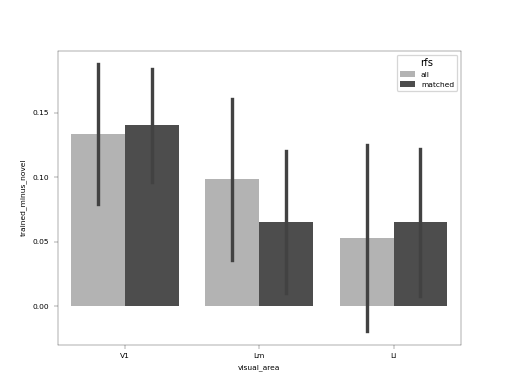

In [70]:
rfmatch_colors={'all': [0.7]*3, 'matched': [0.3]*3}
fig, ax = pl.subplots()

sns.barplot(x='visual_area', y='trained_minus_novel', data=diffdf, ax=ax,
           hue='rfs', palette=rfmatch_colors, order=visual_areas, ci='sd')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2)